# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### Submitted By:
- Kailash Mirani
- Mandheer Singh

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [16]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [17]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size =50 #experiment with the batch size

In [18]:
print(train_doc.shape)
print(val_doc.shape)
train_doc[0].strip().split(';')[2]

(663,)
(100,)


'1'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [19]:
def generator(source_path, folder_list, batch_size,frames_to_sample,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.linspace(0,29,frames_to_sample).astype(int)
    x=len(img_idx)
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(t)//batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    h,w,c=image.shape
                    image=image[10:h-10,10:w-10,:] #cropping image with 10 pixels from each side
                    resized_image=imresize(image,(y,z,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = resized_image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_image[:,:,0]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        remaining_batch= len(t)%batch_size
        if (remaining_batch != 0):
            rem_batch_data=np.zeros((remaining_batch,x,y,z,3))
            rem_batch_labels=np.zeros((remaining_batch,5))
            for folder in range(remaining_batch):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    h,w,c=image.shape
                    image=image[10:h-10,10:w-10,:] #cropping image with 10 pixels from each side
                    resized_image=imresize(image,(y,z,3))
                    rem_batch_data[folder,idx,:,:,0] = resized_image[:,:,0]/255 #normalise and feed in the image
                    rem_batch_data[folder,idx,:,:,1] = resized_image[:,:,0]/255 #normalise and feed in the image
                    rem_batch_data[folder,idx,:,:,2] = resized_image[:,:,0]/255
                rem_batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield rem_batch_data,rem_batch_labels
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


Defining a function to plot model's accuracy and losses

In [21]:
def plot(history):
    f,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[1].plot(history.history['categorical_accuracy'])
    ax[1].plot(history.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [22]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#Function to define and compile a model

def define_model(frames_to_smaple,y,z):
    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same',
     input_shape=(frames_to_smaple,y,z,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))


    model.add(Dense(5,activation='softmax'))
    optimiser = optimizers.Adam()#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model




## Training model on sample data and experimenting with batch_size, image_resolution,frames to sample

First we will try to run model on sample data only

In [10]:
#subsetting the data for ablation experiment
ablation_train_doc=np.random.permutation(train_doc)[:50]
ablation_val_doc=np.random.permutation(val_doc)[:50]

#running generator function to generate data from ablation data
train_ablation_generator = generator(train_path, ablation_train_doc, 50,30,160,160)
val_ablation_generator = generator(val_path, ablation_val_doc, 50,30,160,160)

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(ablation_train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(ablation_val_doc)
print('# validation sequences =', num_val_sequences)
#num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size=50
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 50
# validation sequences = 50


In [11]:
#defining and compiling the model using function
model=define_model(30,160,160)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

Defining Callbacks and filepath to save model

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

Ablation model with Image resolution 160*160, frames to sample=30, batch_size=50

In [24]:
history1=model.fit_generator(train_ablation_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_ablation_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 50
Source path =  Project_data/train ; batch size = 50
Epoch 1/5


ResourceExhaustedError: OOM when allocating tensor with shape[50,32,15,80,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/max_pooling3d_6/MaxPool3D_grad/MaxPool3DGrad = MaxPool3DGrad[T=DT_FLOAT, TInput=DT_FLOAT, _class=["loc:@training/Adam/gradients/batch_normalization_8/cond/Merge_grad/cond_grad"], data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_8/cond/Merge, max_pooling3d_6/MaxPool3D, training/Adam/gradients/conv3d_7/convolution_grad/Conv3DBackpropInputV2)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


We got resource exhausted error trying with less batch_size=40 and frame sample 20

In [25]:
#running generator function to generate data from ablation data
# batch_size=40, Image resolution= 160*160, frames to sample=30
train_ablation_generator = generator(train_path, ablation_train_doc, 40,20,160,160)
val_ablation_generator = generator(val_path, ablation_val_doc, 40,20,160,160)


batch_size=40
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(20,160,160)

history2=model.fit_generator(train_ablation_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_ablation_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_10 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 80, 80, 32)    128       
__________

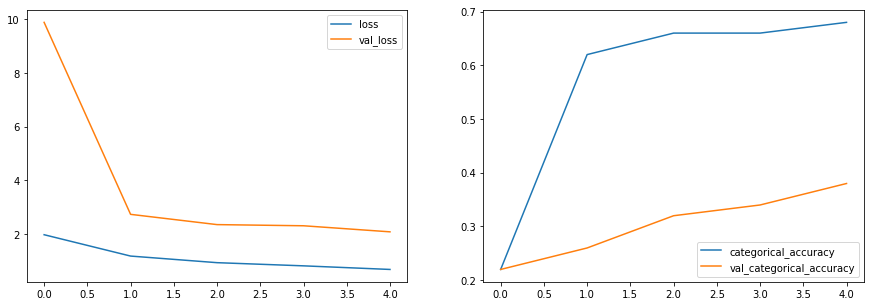

In [26]:
plot(history2)

Running on full data with
- batch_size=40
- frames to sample=20
- Image size= 160*160

In [ ]:
#running generator function to generate data from ablation data
# batch_size=40, Image resolution= 160*160, frames to sample=30
train_generator = generator(train_path, train_doc, 40,20,160,160)
val_generator = generator(val_path, val_doc, 40,20,160,160)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=40
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(20,160,160)

full_model=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_17 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_18 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_

17/17 [==============================] - 59s 3s/step - loss: 0.1233 - categorical_accuracy: 0.9813 - val_loss: 0.6342 - val_categorical_accuracy: 0.7500

Epoch 00017: saving model to model_init_2020-12-2514_48_03.335323/model-00017-0.12155-0.98190-0.63415-0.75000.h5
Epoch 18/20
17/17 [==============================] - 60s 4s/step - loss: 0.1421 - categorical_accuracy: 0.9729 - val_loss: 0.6291 - val_categorical_accuracy: 0.7500

Epoch 00018: saving model to model_init_2020-12-2514_48_03.335323/model-00018-0.13854-0.97436-0.62910-0.75000.h5
Epoch 19/20
13/17 [=====================>........] - ETA: 13s - loss: 0.1317 - categorical_accuracy: 0.9808

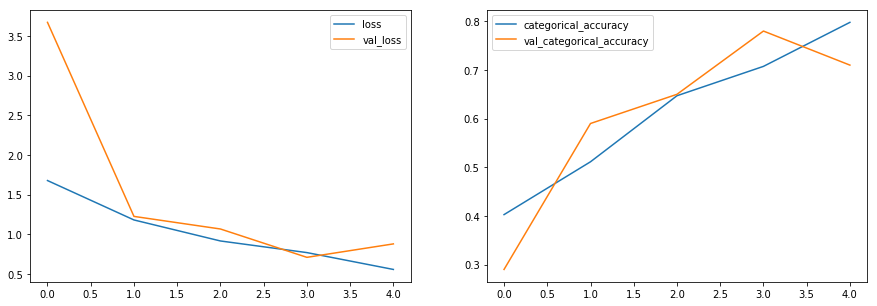

In [28]:
plot(full_model)

### Clearly the model is overfitting we need to do some data augmentation
rewritting generator function with data augmentation

In [24]:
def generator_with_aug(source_path, folder_list, batch_size,frames_to_sample,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.linspace(0,29,frames_to_sample).astype(int)
    x=len(img_idx)
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(t)//batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data_aug = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    h,w,c=image.shape
                    image=image[10:h-10,10:w-10,:] #cropping image with 10 pixels from each side
                    
                    resized_image=imresize(image,(y,z,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = resized_image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_image[:,:,0]/255 #normalise and feed in the image
                    
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(y,z,3))
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        remaining_batch= len(t)%batch_size
        if (remaining_batch != 0):
            rem_batch_data=np.zeros((remaining_batch,x,y,z,3))
            rem_batch_data_aug=np.zeros((remaining_batch,x,y,z,3))
            rem_batch_labels=np.zeros((remaining_batch,5))
            for folder in range(remaining_batch):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    h,w,c=image.shape
                    image=image[10:h-10,10:w-10,:] #cropping image with 10 pixels from each side
                    resized_image=imresize(image,(y,z,3))
                    rem_batch_data[folder,idx,:,:,0] = resized_image[:,:,0]/255 #normalise and feed in the image
                    rem_batch_data[folder,idx,:,:,1] = resized_image[:,:,0]/255 #normalise and feed in the image
                    rem_batch_data[folder,idx,:,:,2] = resized_image[:,:,0]/255
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(y,z,3))
                    rem_batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    rem_batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    rem_batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                rem_batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            rem_batch_data=np.concatenate([rem_batch_data,rem_batch_data_aug])
            rem_batch_labels=np.concatenate([rem_batch_labels,rem_batch_labels])
            yield rem_batch_data,rem_batch_labels
        # write the code for the remaining data points which are left after full batches


Running on full data with
- batch_size=20
- frames to sample=20
- Image size= 160*160

In [14]:
#defining model
def define_model(frames_to_smaple,y,z):
    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same',
     input_shape=(frames_to_smaple,y,z,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(5,activation='softmax'))
    optimiser = optimizers.Adam()#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model



train_generator = generator_with_aug(train_path, train_doc, 20,20,160,160)
val_generator = generator_with_aug(val_path, val_doc, 20,20,160,160)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(20,160,160)

full_model2=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_6 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_

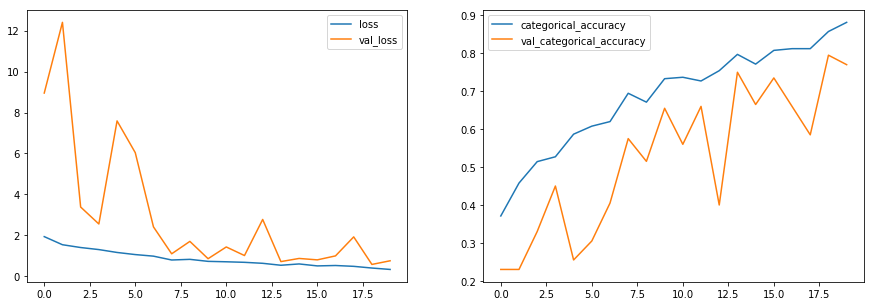

In [15]:
plot(full_model2)

Best validation accuracy 77%

Running on full data with augmentation and reduced filter size(2,2,2)
- batch_size=30
- frames to sample=20
- Image size= 140*140

In [16]:
#defining model
def define_model(frames_to_smaple,y,z):
    model = Sequential()
    model.add(Conv3D(16, (2, 2, 2), padding='same',
     input_shape=(frames_to_smaple,y,z,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))


    model.add(Dense(5,activation='softmax'))
    optimiser = optimizers.Adam()#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model



train_generator = generator_with_aug(train_path, train_doc, 30,20,140,140)
val_generator = generator_with_aug(val_path, val_doc, 30,20,140,140)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=30
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(20,140,140)

full_model3=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 140, 140, 16)  400       
_________________________________________________________________
activation_9 (Activation)    (None, 20, 140, 140, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 140, 140, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 70, 70, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 70, 70, 32)    4128      
_________________________________________________________________
activation_10 (Activation)   (None, 10, 70, 70, 32)    0         
_________________________________________________________________
batch_normalization_

23/23 [==============================] - 103s 4s/step - loss: 0.3335 - categorical_accuracy: 0.8844 - val_loss: 0.7124 - val_categorical_accuracy: 0.7450

Epoch 00017: saving model to model_init_2020-12-2615_15_51.457218/model-00017-0.30830-0.89291-0.71239-0.74500.h5
Epoch 18/20
23/23 [==============================] - 103s 4s/step - loss: 0.2802 - categorical_accuracy: 0.9122 - val_loss: 0.6505 - val_categorical_accuracy: 0.7700

Epoch 00018: saving model to model_init_2020-12-2615_15_51.457218/model-00018-0.28546-0.90875-0.65054-0.77000.h5
Epoch 19/20
23/23 [==============================] - 103s 4s/step - loss: 0.2945 - categorical_accuracy: 0.8818 - val_loss: 0.5805 - val_categorical_accuracy: 0.8150

Epoch 00019: saving model to model_init_2020-12-2615_15_51.457218/model-00019-0.28266-0.89668-0.58051-0.81500.h5
Epoch 20/20
23/23 [==============================] - 103s 4s/step - loss: 0.2529 - categorical_accuracy: 0.9139 - val_loss: 0.6113 - val_categorical_accuracy: 0.8050

Epoch

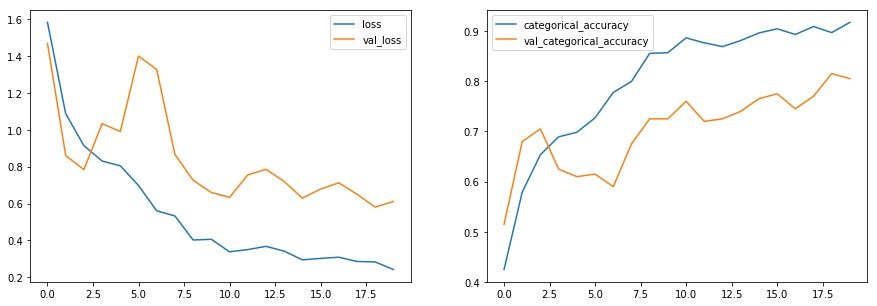

In [17]:
plot(full_model3)

Running on full data with augmentation and reduced filter size(2,2,2)
- batch_size=30
- frames to sample=16
- Image size= 120*120

In [18]:
#defining model
def define_model(frames_to_smaple,y,z):
    model = Sequential()
    model.add(Conv3D(16, (2, 2, 2), padding='same',
     input_shape=(frames_to_smaple,y,z,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(5,activation='softmax'))
    optimiser = optimizers.Adam()#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model



train_generator = generator_with_aug(train_path, train_doc, 30,16,120,120)
val_generator = generator_with_aug(val_path, val_doc, 30,16,120,120)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=30
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(16,120,120)

full_model4=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_14 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_

23/23 [==============================] - 74s 3s/step - loss: 0.4510 - categorical_accuracy: 0.8348 - val_loss: 0.9026 - val_categorical_accuracy: 0.7300

Epoch 00017: saving model to model_init_2020-12-2615_15_51.457218/model-00017-0.45790-0.83484-0.90262-0.73000.h5

Epoch 00017: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 18/30
23/23 [==============================] - 73s 3s/step - loss: 0.5524 - categorical_accuracy: 0.8170 - val_loss: 0.8385 - val_categorical_accuracy: 0.7350

Epoch 00018: saving model to model_init_2020-12-2615_15_51.457218/model-00018-0.42338-0.84238-0.83853-0.73500.h5
Epoch 19/30
23/23 [==============================] - 74s 3s/step - loss: 0.5586 - categorical_accuracy: 0.8149 - val_loss: 0.7915 - val_categorical_accuracy: 0.7600

Epoch 00019: saving model to model_init_2020-12-2615_15_51.457218/model-00019-0.43043-0.84012-0.79151-0.76000.h5
Epoch 20/30
23/23 [==============================] - 73s 3s/step - loss: 0.3973 - categorical

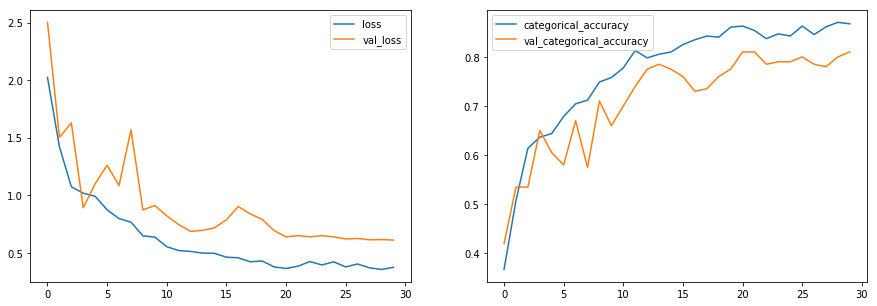

In [19]:
plot(full_model4)

Above model is not overfitting and having best validation accuracy of 81%

Running on full data with augmentation and adding more layers
- batch_size=20
- frames to sample=20
- Image size= 120*120

In [24]:
#defining model
def define_model(frames_to_smaple,y,z):
    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same',
     input_shape=(frames_to_smaple,y,z,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    

    model.add(Conv3D(16, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    

    model.add(Conv3D(32, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    
    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(5,activation='softmax'))
    optimiser = optimizers.Adam()#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model



train_generator = generator_with_aug(train_path, train_doc, 20,20,120,120)
val_generator = generator_with_aug(val_path, val_doc, 20,20,120,120)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(20,120,120)

full_model5=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_38 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_37 (Ma

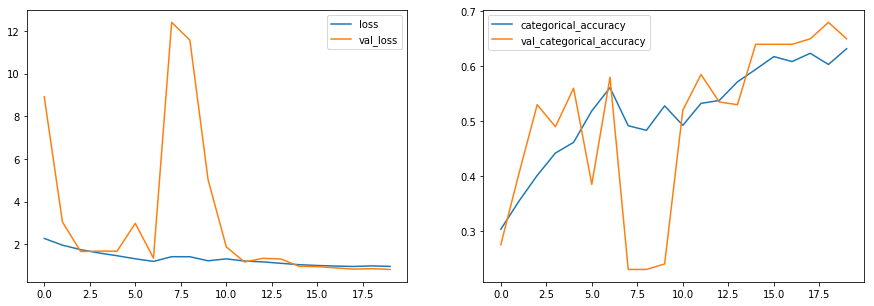

In [26]:
plot(full_model5)

Performance did not improved

Running on full data with augmentation
Trying to reduce number of parameters
- batch_size=20
- frames to sample=16
- Image size= 100*100

In [27]:
#defining model
def define_model(frames_to_smaple,y,z):
    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same',
     input_shape=(frames_to_smaple,y,z,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))


    model.add(Dense(5,activation='softmax'))
    optimiser = optimizers.Adam()#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model



train_generator = generator_with_aug(train_path, train_doc, 20,16,100,100)
val_generator = generator_with_aug(val_path, val_doc, 20,16,100,100)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(16,100,100)

full_model6=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_43 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_43 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_44 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_44 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_

34/34 [==============================] - 70s 2s/step - loss: 0.6167 - categorical_accuracy: 0.7623 - val_loss: 0.7267 - val_categorical_accuracy: 0.7350

Epoch 00017: saving model to model_init_2020-12-2615_15_51.457218/model-00017-0.60930-0.76471-0.72666-0.73500.h5
Epoch 18/20
34/34 [==============================] - 70s 2s/step - loss: 0.5996 - categorical_accuracy: 0.7689 - val_loss: 0.7391 - val_categorical_accuracy: 0.7500

Epoch 00018: saving model to model_init_2020-12-2615_15_51.457218/model-00018-0.60103-0.77149-0.73910-0.75000.h5
Epoch 19/20
34/34 [==============================] - 70s 2s/step - loss: 0.5576 - categorical_accuracy: 0.7770 - val_loss: 0.7145 - val_categorical_accuracy: 0.7400

Epoch 00019: saving model to model_init_2020-12-2615_15_51.457218/model-00019-0.53958-0.78808-0.71448-0.74000.h5
Epoch 20/20
34/34 [==============================] - 70s 2s/step - loss: 0.5466 - categorical_accuracy: 0.8024 - val_loss: 0.7260 - val_categorical_accuracy: 0.7450

Epoch 000

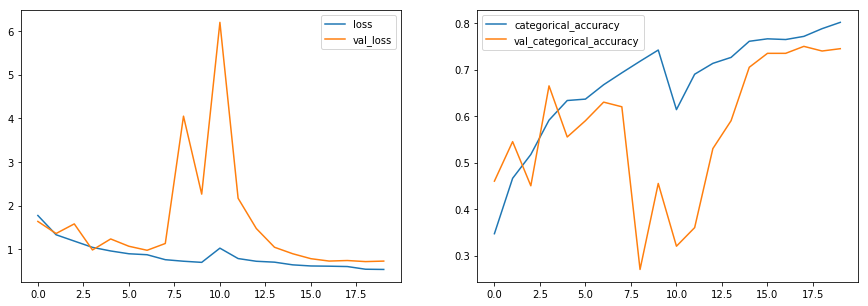

In [28]:
plot(full_model6)

## Transfer Learning + RNN model

In [38]:
from keras.applications.vgg16 import VGG16
from keras.layers import LSTM,MaxPooling2D

In [33]:
#Using VGG model with trainable=False

vgg=VGG16(weights='imagenet',include_top=False)
def define_model(frames_to_sample,y,z):
    model = Sequential()
    model.add(TimeDistributed(vgg,input_shape=(frames_to_sample,y,z,3)))
        
        
    for layer in model.layers:
            layer.trainable = False
        
        
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64))
    model.add(Dropout(0.25))
        
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(5, activation='softmax'))
        
        
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print(model.summary())
    return model

train_generator = generator_with_aug(train_path, train_doc, 20,16,120,120)
val_generator = generator_with_aug(val_path, val_doc, 20,16,120,120)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(16,120,120)

full_model7=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 16, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 3, 3, 512)     2048      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)    

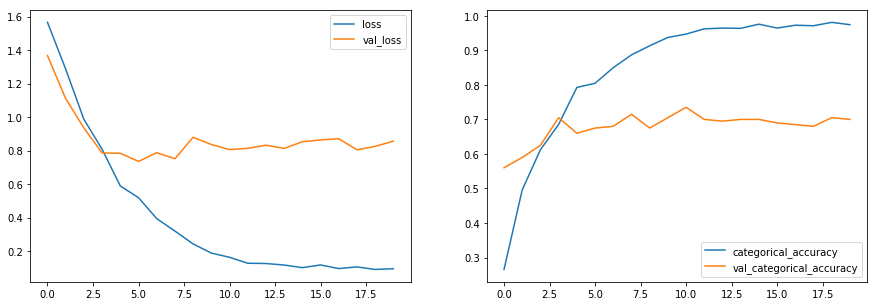

In [34]:
plot(full_model7)

Using lightweight mobilenet with gru for model

In [35]:
from keras.applications import MobileNet

In [15]:
mobilenet = MobileNet(weights='imagenet', include_top=False)


def define_model(frames_to_sample,y,z):
    model = Sequential()
    model.add(TimeDistributed(mobilenet,input_shape=(frames_to_sample,y,z,3)))
        
        
    for layer in model.layers:
            layer.trainable = False
        
        
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(128))
    model.add(Dropout(0.25))
        
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(5, activation='softmax'))
        
        
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print(model.summary())
    return model

train_generator = generator_with_aug(train_path, train_doc, 20,16,120,120)
val_generator = generator_with_aug(val_path, val_doc, 20,16,120,120)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(16,120,120)

full_model8=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

17227776/17225924 [==============================] - 2s 0us/step
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_____________________

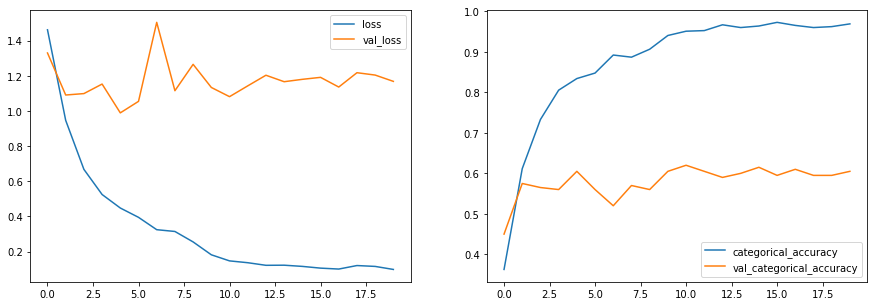

In [16]:
plot(full_model8)

Running model with all weights trained

In [20]:
mobilenet = MobileNet(weights='imagenet', include_top=False)


def define_model(frames_to_sample,y,z):
    model = Sequential()
    model.add(TimeDistributed(mobilenet,input_shape=(frames_to_sample,y,z,3)))
        
        
    
        
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(128))
    model.add(Dropout(0.25))
        
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(5, activation='softmax'))
        
        
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print(model.summary())
    return model

train_generator = generator_with_aug(train_path, train_doc, 5,16,120,120)
val_generator = generator_with_aug(val_path, val_doc, 5,16,120,120)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=5
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(16,120,120)

full_model9=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)     

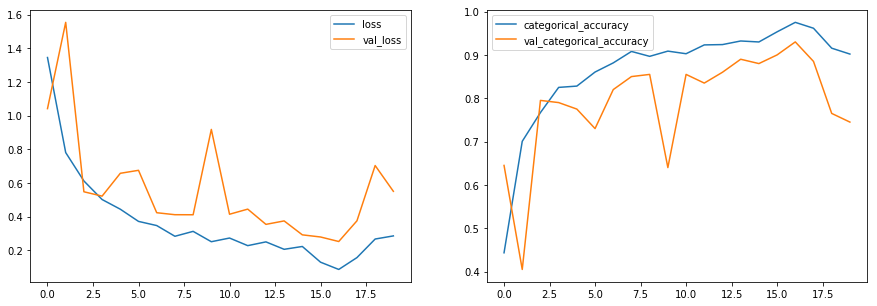

In [21]:
plot(full_model9)

best val accuracy was 93%.model was overfitting on last few epochs increasing dropout and using batch normalization

In [36]:
mobilenet = MobileNet(weights='imagenet', include_top=False)

In [39]:
def define_model(frames_to_sample,y,z):
    model = Sequential()
    model.add(TimeDistributed(mobilenet,input_shape=(frames_to_sample,y,z,3)))
        
        
    
        
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(128))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
        
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
        
    model.add(Dense(5, activation='softmax'))
        
        
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print(model.summary())
    return model

train_generator = generator_with_aug(train_path, train_doc, 10,16,120,120)
val_generator = generator_with_aug(val_path, val_doc, 10,16,120,120)

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


batch_size=10
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
model=define_model(16,120,120)

full_model10=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout) 

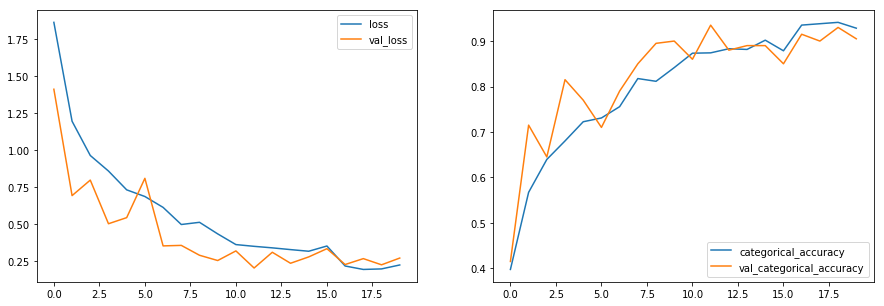

In [40]:
plot(full_model10)

### Final Model
testing the model on one batch

In [25]:
from keras.models import load_model
model = load_model('model_init_2020-12-2712_11_26.467901/model-00017-0.08752-0.97511-0.25327-0.93000.h5')

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [31]:
val_generator = generator_with_aug(val_path, val_doc, 5,16,120,120)
batch_data,batch_label=next(val_generator)

Source path =  Project_data/val ; batch size = 5


In [32]:
#true labels
np.argmax(batch_label,axis=1)

array([3, 0, 2, 1, 1, 3, 0, 2, 1, 1])

In [33]:
#predicted labels
np.argmax(model.predict(batch_data[:,:,:,:]),axis=1)

array([3, 0, 2, 1, 1, 3, 0, 2, 1, 1])